In [5]:

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import os

from model import *

from collections import OrderedDict
import pickle5 as pickle


device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

class CustomDataset_Nolabel(torch.utils.data.Dataset):
  
    def __init__(self, imgs, transform=None):
        """
        Arguments:
            
        """
        self.images = imgs
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = self.images[idx,:]
        if self.transform:
            image = self.transform(image)
        image = torch.tensor(image)
        return image ,idx


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = './data_course/'



# Load test batch
test_batch = load_cifar_batch(os.path.join(cifar10_dir, 'cifar_test_nolabels.pkl'))
test_images = test_batch[b'data']
test_images = test_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)



test_dataset = CustomDataset_Nolabel(test_images,transform= transform_test)
testloader_course = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=16)


# Model


def ResNet18():
    return ResNet(BasicBlock, [2, 1, 1, 1])

net = ResNet18()
# net = ResNet18()

lr = .1
epochs = 200

net = net.to(device)
state_dict = torch.load("files/saved_model.pth",map_location=device)
if device == 'cuda':
    net.net.load_state_dict(state_dict)

else:
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        if 'module' in k:
            k = k[7:]
        new_state_dict[k]=v
    net.load_state_dict(new_state_dict)

    


criterion = nn.CrossEntropyLoss()


def test(test_loader):
    net.eval()
    
    aux_list = []
    with torch.no_grad():
        for _, (inputs, idxs) in enumerate(test_loader):
            inputs, idxs = inputs.to(device), idxs
            outputs = net(inputs)
            _, predicteds = outputs.max(1)
            for i in range(len(idxs)):
                idx = idxs[i].item()
                predicted = predicteds[i].item()
                aux_dict = {"ID":idx, "Labels":predicted}
                aux_list.append(aux_dict)

    return aux_list

result = test(test_loader=testloader_course)
    

c:\Users\felip\Documents\Github\Resnet_Cifar10\venv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Creating df Submission

In [2]:
import pandas as pd 
df = pd.DataFrame.from_records(result)

In [3]:
df.head(10)

,ID,Labels
0,0,8
1,1,8
2,2,8
3,3,0
4,4,8
5,5,8
6,6,8
7,7,7
8,8,8
9,9,9


In [16]:
df.to_csv('out.csv', index=False)

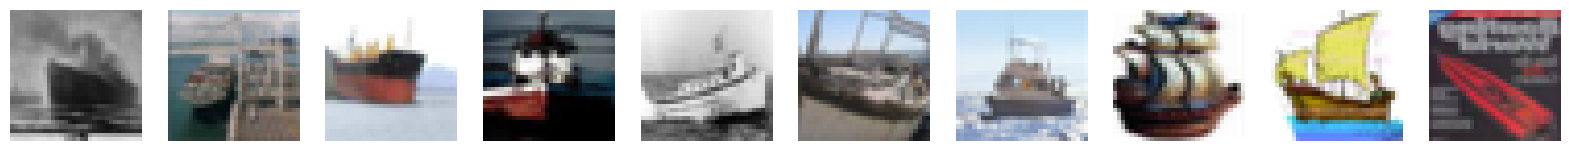

In [4]:
import matplotlib.pyplot as plt
# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i])
    plt.axis('off')
plt.show()